In [652]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

from xgboost import XGBRegressor

In [653]:
def load_data(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

train_path  = "regression-dataset-train.csv"
test_path = "regression-dataset-test-unlabeled.csv"
df_train, df_test = load_data(train_path, test_path)

df_train = df_train.drop(['id'], axis =1)


df_train.head()

date  season_id  year  month  is_holiday  weekday  is_workingday  \
0  31-07-2019          3     1      7           0        2              1   
1  03-03-2019          1     1      3           0        6              0   
2  30-12-2019          1     1     12           0        0              0   
3  28-04-2019          2     1      4           0        6              0   
4  22-04-2018          2     0      4           0        5              1   

   weather_condition  temperature  feels_like_temp  humidity  wind_speed  \
0                  1    29.246653          33.1448   70.4167   11.083475   
1                  2    16.980847          20.6746   62.1250   10.792293   
2                  1    10.489153          11.5850   48.3333   23.500518   
3                  2    15.443347          18.8752   48.9583    8.708325   
4                  2    13.803347          16.0977   72.9583   14.707907   

   total_users  
0         7216  
1         4066  
2         1796  
3         4220  
4         1683

In [654]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               510 non-null    object 
 1   season_id          510 non-null    int64  
 2   year               510 non-null    int64  
 3   month              510 non-null    int64  
 4   is_holiday         510 non-null    int64  
 5   weekday            510 non-null    int64  
 6   is_workingday      510 non-null    int64  
 7   weather_condition  510 non-null    int64  
 8   temperature        510 non-null    float64
 9   feels_like_temp    510 non-null    float64
 10  humidity           510 non-null    float64
 11  wind_speed         510 non-null    float64
 12  total_users        510 non-null    int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 51.9+ KB


In [655]:
print(df_train.isna().sum().sum())
print(df_test.isna().sum().sum())

0
0


In [656]:
df_train = df_train.drop('date', axis=1)
df_test = df_test.drop('date', axis=1)
df_train.head()
# df_train['date'] = pd.to_datetime(df_train['date'], format='%d-%m-%Y')
# df_test['date'] = pd.to_datetime(df_test['date'], format='%d-%m-%Y')



season_id  year  month  is_holiday  weekday  is_workingday  \
0          3     1      7           0        2              1   
1          1     1      3           0        6              0   
2          1     1     12           0        0              0   
3          2     1      4           0        6              0   
4          2     0      4           0        5              1   

   weather_condition  temperature  feels_like_temp  humidity  wind_speed  \
0                  1    29.246653          33.1448   70.4167   11.083475   
1                  2    16.980847          20.6746   62.1250   10.792293   
2                  1    10.489153          11.5850   48.3333   23.500518   
3                  2    15.443347          18.8752   48.9583    8.708325   
4                  2    13.803347          16.0977   72.9583   14.707907   

   total_users  
0         7216  
1         4066  
2         1796  
3         4220  
4         1683

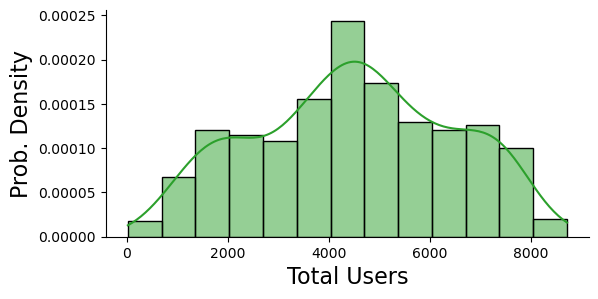

In [657]:
sns.displot(df_train['total_users'], kde=True, height=3, aspect=2, stat='density', color='tab:green')
plt.xlabel('Total Users', fontsize=16)
plt.ylabel('Prob. Density', fontsize=16)
plt.show()


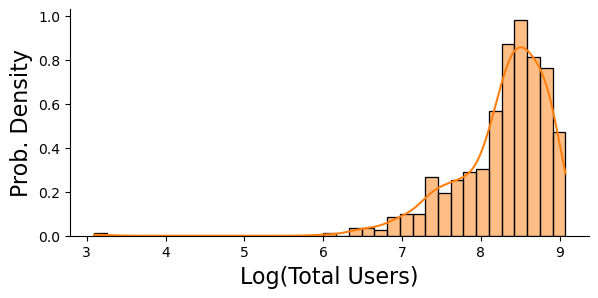

In [658]:
sns.displot(np.log(df_train['total_users']), kde=True, height=3, aspect=2, stat='density', color='tab:orange')
plt.xlabel('Log(Total Users)', fontsize=16)
plt.ylabel('Prob. Density', fontsize=16)
plt.show()

So taking the total_users is better than the log of the total_users because it is slightly more notmally distributed.

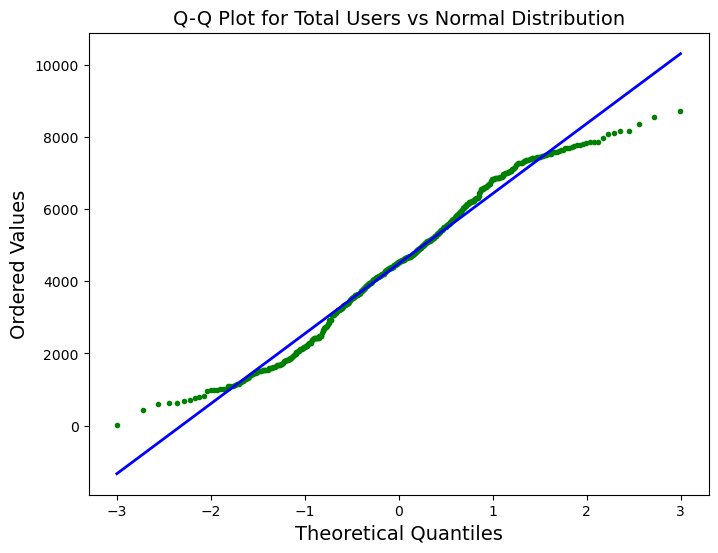

In [659]:
import matplotlib.pyplot as plt
import scipy.stats

fig, ax = plt.subplots(figsize=(8, 6))
scipy.stats.probplot(df_train['total_users'], dist="norm", fit=True, plot=ax)

ax.set_title('Q-Q Plot for Total Users vs Normal Distribution', fontsize=14)
ax.set_xlabel('Theoretical Quantiles', fontsize=14)
ax.set_ylabel('Ordered Values', fontsize=14)
ax.get_lines()[0].set_marker('.')
ax.get_lines()[0].set_markerfacecolor('g')
ax.get_lines()[0].set_markeredgecolor('g')
ax.get_lines()[1].set_linewidth(2.0)
ax.get_lines()[1].set_color('b')
plt.show()


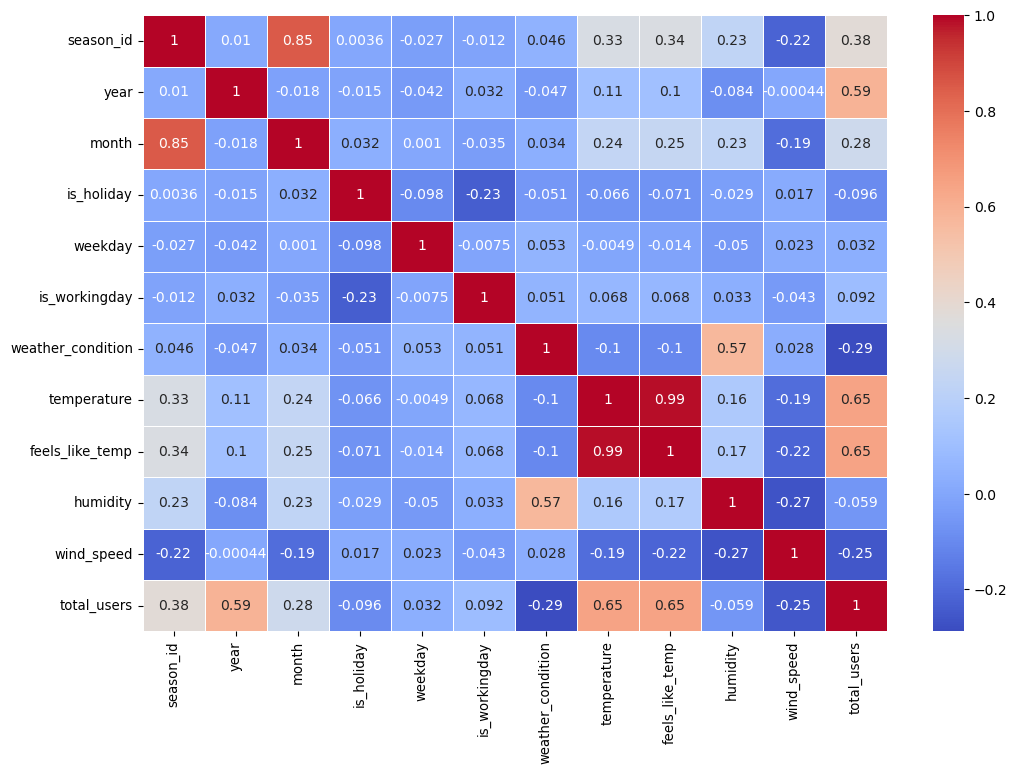

In [660]:
plt.figure(figsize=(12,8))
corr = df_train.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, linewidths=.5, cmap='coolwarm', annot=True)
plt.xticks(fontsize=9.5)
plt.yticks(fontsize=9.5)
plt.show()

In [661]:
print(df_train.corr())

                   season_id      year     month  is_holiday   weekday  \
season_id           1.000000  0.010414  0.851850    0.003607 -0.026697   
year                0.010414  1.000000 -0.018313   -0.014980 -0.041769   
month               0.851850 -0.018313  1.000000    0.032215  0.001042   
is_holiday          0.003607 -0.014980  0.032215    1.000000 -0.097993   
weekday            -0.026697 -0.041769  0.001042   -0.097993  1.000000   
is_workingday      -0.012226  0.031808 -0.034753   -0.233863 -0.007524   
weather_condition   0.045775 -0.047405  0.033648   -0.051163  0.053367   
temperature         0.328975  0.108054  0.240307   -0.066405 -0.004918   
feels_like_temp     0.337238  0.104971  0.248223   -0.070760 -0.014307   
humidity            0.229128 -0.084061  0.228566   -0.029224 -0.050116   
wind_speed         -0.217737 -0.000439 -0.189047    0.017458  0.023469   
total_users         0.380205  0.591433  0.283249   -0.095948  0.032425   

                   is_workingday  wea

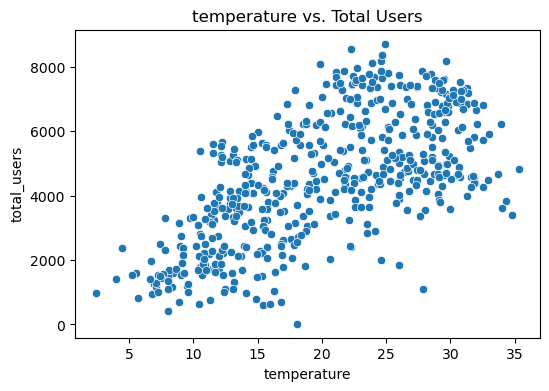

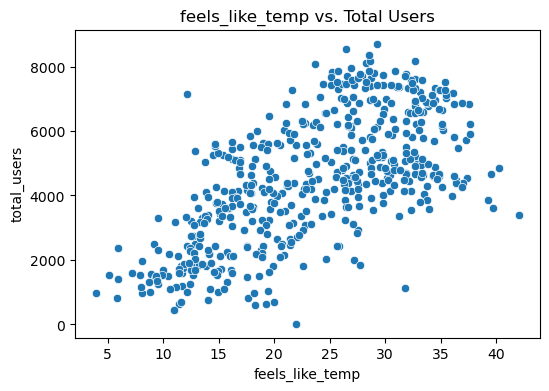

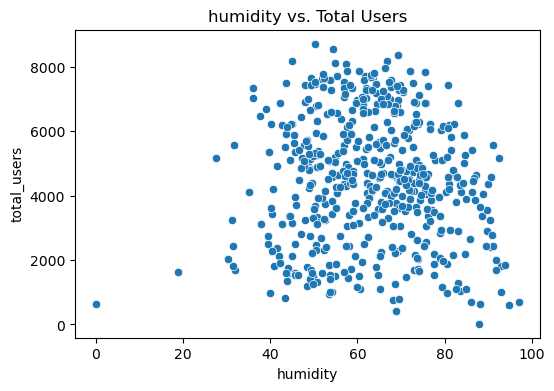

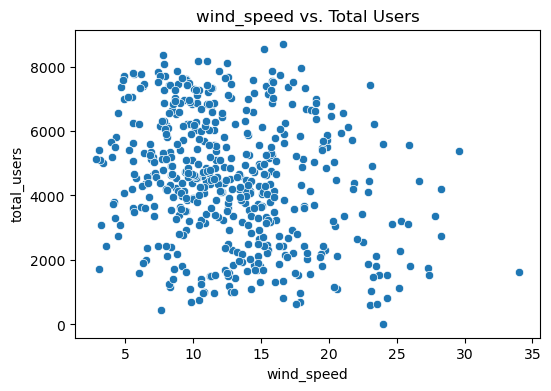

In [662]:
numerical_features = ['temperature', 'feels_like_temp', 'humidity', 'wind_speed']
for feature in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df_train[feature], y=df_train['total_users'])
    plt.title(f"{feature} vs. Total Users")
    plt.show()

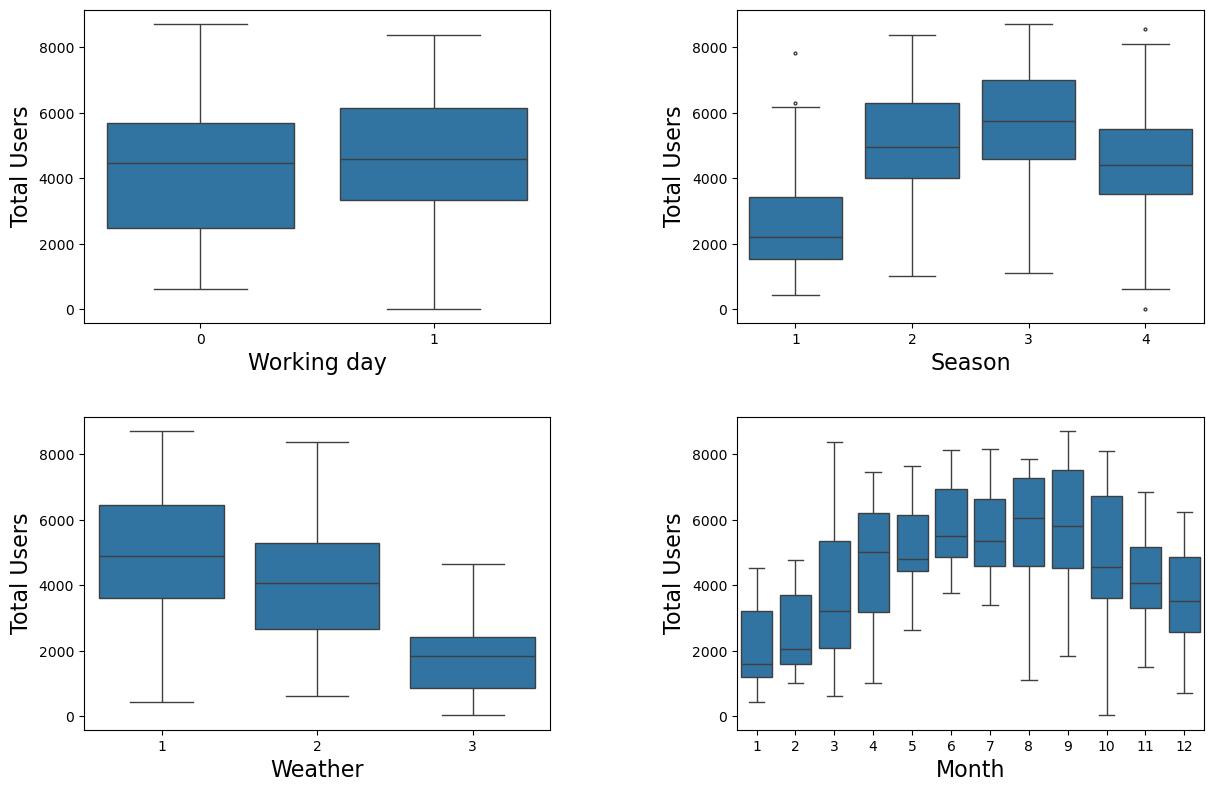

In [663]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(14,9)
sns.boxplot(data=df_train, y="total_users", x="is_workingday", ax=axs[0][0], fliersize=2)
sns.boxplot(data=df_train, y="total_users", x="season_id", ax=axs[0][1], fliersize=2)
sns.boxplot(data=df_train, y="total_users", x="weather_condition", ax=axs[1][0], fliersize=2)
sns.boxplot(data=df_train, y="total_users", x="month", ax=axs[1][1], fliersize=2)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.3)
axs[0][0].set_xlabel('Working day', fontsize=16)
axs[0][0].set_ylabel('Total Users', fontsize=16)
axs[0][1].set_xlabel('Season', fontsize=16)
axs[0][1].set_ylabel('Total Users', fontsize=16)
axs[1][0].set_xlabel('Weather', fontsize=16)
axs[1][0].set_ylabel('Total Users', fontsize=16)
axs[1][1].set_xlabel('Month', fontsize=16)
axs[1][1].set_ylabel('Total Users', fontsize=16)
plt.show()

In [664]:
def engineer_features(df):
    df['month_sin'] = np.sin((df['month']-1)*(2*np.pi/12))
    df['month_cos'] = np.cos((df['month']-1)*(2*np.pi/12))
    df['weekday_sin'] = np.sin(df['weekday']*(2*np.pi/7))
    df['weekday_cos'] = np.cos(df['weekday']*(2*np.pi/7))
    
    df = pd.get_dummies(df, columns=['weather_condition'], prefix='weather', drop_first=True)

    # df['is_weekend'] = (df['weekday'] >= 5).astype(int)
    # df['temp_squared'] = df['temperature'] ** 2
    # special_dates = ['01-01-2018', '25-12-2018', '01-01-2019', '25-12-2019']
    # df['is_special_event'] = df['date'].isin(special_dates).astype(int)
    # df['temp_weather_2'] = df['temperature'] * df['weather_2']
    # df['temp_weather_3'] = df['temperature'] * df['weather_3']
    # df= df.drop(['date'],axis=1)
    # Interaction features
    #df['temp_weekend'] = df['temperature'] * (df['day_of_week'] >= 5).astype(int)
    
    # Drop original date
    return df

df_train = engineer_features(df_train)
df_test = engineer_features(df_test)

df_train.head()



season_id  year  month  is_holiday  weekday  is_workingday  temperature  \
0          3     1      7           0        2              1    29.246653   
1          1     1      3           0        6              0    16.980847   
2          1     1     12           0        0              0    10.489153   
3          2     1      4           0        6              0    15.443347   
4          2     0      4           0        5              1    13.803347   

   feels_like_temp  humidity  wind_speed  total_users     month_sin  \
0          33.1448   70.4167   11.083475         7216  1.224647e-16   
1          20.6746   62.1250   10.792293         4066  8.660254e-01   
2          11.5850   48.3333   23.500518         1796 -5.000000e-01   
3          18.8752   48.9583    8.708325         4220  1.000000e+00   
4          16.0977   72.9583   14.707907         1683  1.000000e+00   

      month_cos  weekday_sin  weekday_cos  weather_2  weather_3  
0 -1.000000e+00     0.974928    -0.222521      False      False  
1  5.000000e-01    -0.781831     0.623490       True      False  
2  8.660254e-01     0.000000     1.000000      False      False  
3  6.123234e-17    -0.781831     0.623490       True      False  
4  6.123234e-17    -0.974928    -0.222521       True      False

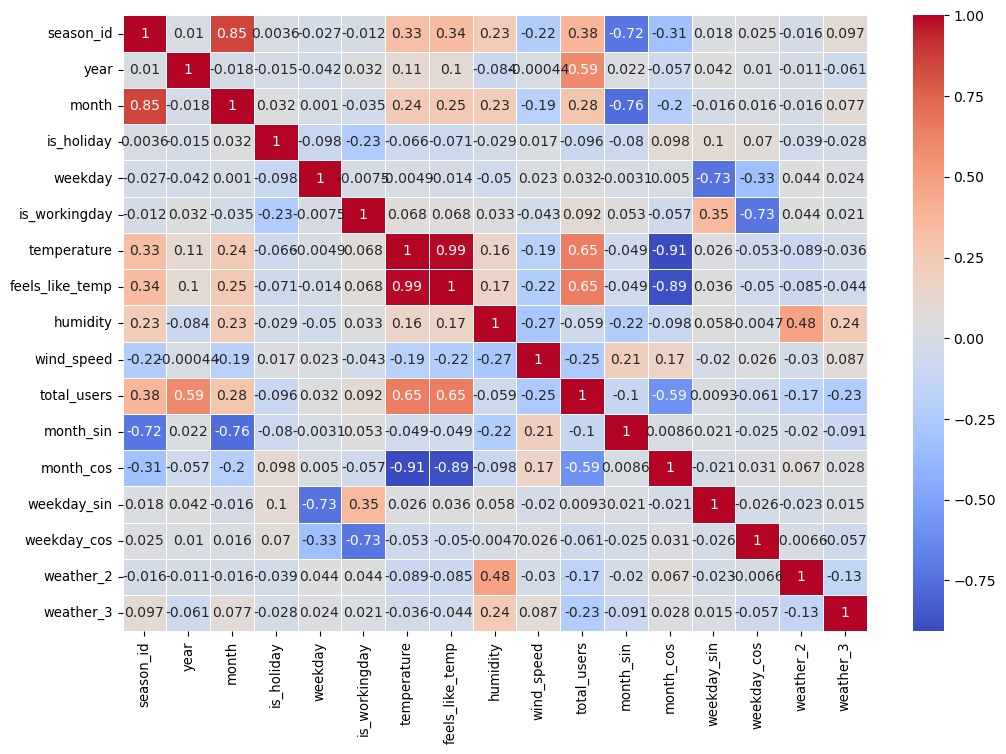

In [665]:
plt.figure(figsize=(12,8))
corr = df_train.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, linewidths=.5, cmap='coolwarm', annot=True)
plt.xticks(fontsize=9.5)
plt.yticks(fontsize=9.5)
plt.show()

In [666]:
df_train = df_train.drop(['feels_like_temp','month', 'weekday'],axis =1)
df_test = df_test.drop(['feels_like_temp','month', 'weekday'], axis = 1)

In [667]:
df_train['season_cycle'] = (df_train['year'] - df_train['year'].min()) * 4 + df_train['season_id']
df_test['season_cycle'] = (df_test['year'] - df_test['year'].min()) * 4 + df_test['season_id']

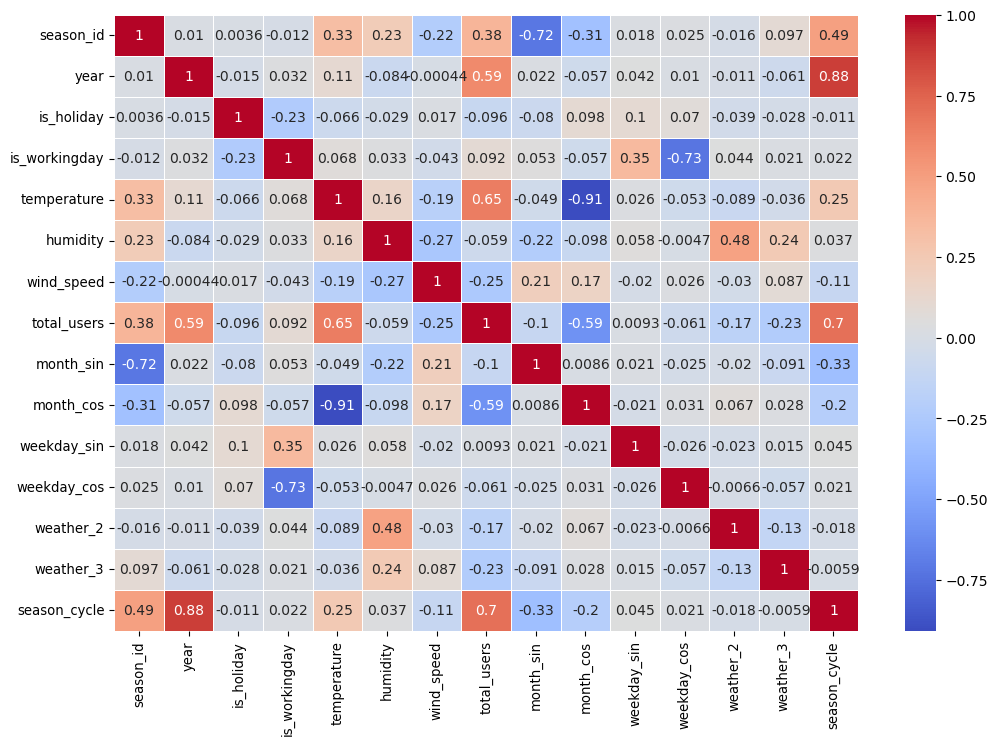

In [668]:
plt.figure(figsize=(12,8))
corr = df_train.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, linewidths=.5, cmap='coolwarm', annot=True)
plt.xticks(fontsize=9.5)
plt.yticks(fontsize=9.5)
plt.show()


In [669]:
# df_train['temp_humidity'] = df_train['temperature'] * df_train['humidity']
# plt.figure(figsize=(8,5))
# sns.scatterplot(x=df_train['temp_humidity'], y=df_train['total_users'])
# plt.title("temp_humidity vs Bike Rentals")
# plt.show()

In [670]:
# plt.figure(figsize=(12,8))
# corr = df_train.corr()
# sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, linewidths=.5, cmap='coolwarm', annot=True)
# plt.xticks(fontsize=9.5)
# plt.yticks(fontsize=9.5)
# plt.show()

In [671]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_train = df_train.drop(['total_users'], axis=1)
y = df_train['total_users']

X_test = df_test.drop(['id'],axis=1)

scaler = StandardScaler()
X_scaled_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

X_scaled_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)



In [672]:
vif = pd.DataFrame()
vif['Features'] = X_scaled_train.columns
vif['VIF'] = [variance_inflation_factor(X_scaled_train.values, i) for i in range(X_scaled_train.shape[1])]
vif['VIF'] = vif['VIF'].round(2)
vif = vif.sort_values(by='VIF', ascending=False)
print(vif)

         Features   VIF
0       season_id   inf
1            year   inf
13   season_cycle   inf
4     temperature  6.35
8       month_cos  6.17
3   is_workingday  3.21
10    weekday_cos  2.61
7       month_sin  2.38
5        humidity  1.90
11      weather_2  1.58
9     weekday_sin  1.42
12      weather_3  1.25
2      is_holiday  1.20
6      wind_speed  1.19


c:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [673]:
X_scaled_train = X_scaled_train.drop(['year'], axis = 1)
X_scaled_test = X_scaled_test.drop(['year'], axis =1)

In [674]:
vif = pd.DataFrame()
vif['Features'] = X_scaled_train.columns
vif['VIF'] = [variance_inflation_factor(X_scaled_train.values, i) for i in range(X_scaled_train.shape[1])]
vif['VIF'] = vif['VIF'].round(2)
vif = vif.sort_values(by='VIF', ascending=False)
print(vif)

         Features   VIF
3     temperature  6.35
7       month_cos  6.17
2   is_workingday  3.21
0       season_id  2.94
9     weekday_cos  2.61
6       month_sin  2.38
4        humidity  1.90
10      weather_2  1.58
8     weekday_sin  1.42
12   season_cycle  1.38
11      weather_3  1.25
1      is_holiday  1.20
5      wind_speed  1.19


In [675]:
X_scaled_sm = sm.add_constant(X_scaled_train)

ols_model = sm.OLS(y, X_scaled_sm).fit()

print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:            total_users   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     169.4
Date:                Tue, 13 May 2025   Prob (F-statistic):          6.62e-173
Time:                        19:34:33   Log-Likelihood:                -4154.9
No. Observations:                 510   AIC:                             8338.
Df Residuals:                     496   BIC:                             8397.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4485.3373     37.514    119.563

In [676]:
# season_id	0.579
# is_workingday	0.524
# weekday_sin	0.125
# weekday_cos
X_scaled_train = X_scaled_train.drop(['season_id'],axis=1)
X_scaled_sm = sm.add_constant(X_scaled_train)

ols_model = sm.OLS(y, X_scaled_sm).fit()

print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:            total_users   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     183.8
Date:                Tue, 13 May 2025   Prob (F-statistic):          5.57e-174
Time:                        19:34:33   Log-Likelihood:                -4155.1
No. Observations:                 510   AIC:                             8336.
Df Residuals:                     497   BIC:                             8391.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4485.3373     37.488    119.646

In [677]:
X_scaled_train = X_scaled_train.drop(['is_workingday'],axis=1)
X_scaled_sm = sm.add_constant(X_scaled_train)

ols_model = sm.OLS(y, X_scaled_sm).fit()

print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:            total_users   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     200.7
Date:                Tue, 13 May 2025   Prob (F-statistic):          4.72e-175
Time:                        19:34:33   Log-Likelihood:                -4155.3
No. Observations:                 510   AIC:                             8335.
Df Residuals:                     498   BIC:                             8385.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4485.3373     37.466    119.717   

In [678]:
X_scaled_train = X_scaled_train.drop(['weekday_sin'],axis=1)
X_scaled_sm = sm.add_constant(X_scaled_train)

ols_model = sm.OLS(y, X_scaled_sm).fit()

print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:            total_users   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     220.1
Date:                Tue, 13 May 2025   Prob (F-statistic):          8.25e-176
Time:                        19:34:33   Log-Likelihood:                -4156.3
No. Observations:                 510   AIC:                             8335.
Df Residuals:                     499   BIC:                             8381.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4485.3373     37.503    119.600   

In [679]:
# X_scaled_train = X_scaled_train.drop(['weekday_cos'],axis=1)
# X_scaled_sm = sm.add_constant(X_scaled_train)

# ols_model = sm.OLS(y, X_scaled_sm).fit()

# print(ols_model.summary())


So as the result removing the weekday_cos wasnt beneficial to the model 

In [680]:
df_train = df_train.drop(columns=['season_id', 'is_workingday', 'weekday_sin'])
df_test = df_test.drop(columns=['id','season_id', 'is_workingday', 'weekday_sin'])
# df_test = df_test.drop(['id'],axis=1)


In [681]:
X = df_train.drop(columns=['total_users'])
y = df_train['total_users']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_final = scaler.transform(df_test)


In [682]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=0.1),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
}

# Train models, evaluate, and save test predictions
for name, model in models.items():
    model.fit(X_scaled, y)
    y_pred = model.predict(X_scaled)

    # Evaluation on training data
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    print(f"{name}:")
    print(f"  MSE: {mse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R²: {r2:.3f}")
    print("-" * 30)

    # Predict on test data
    test_pred = model.predict(X_test_final)

    # Build dataframe
    result_df = pd.DataFrame({
        "id": range(1, len(test_pred) + 1),
        "label": test_pred
    })

    # Clean file name
    file_safe_name = name.lower().replace(" ", "_") + "_2predictions.csv"

    # Save CSV
    result_df.to_csv(file_safe_name, index=False)


Linear Regression:
  MSE: 701424.77
  MAE: 609.35
  R²: 0.815
------------------------------
Ridge Regression:
  MSE: 701425.59
  MAE: 609.39
  R²: 0.815
------------------------------
Decision Tree:
  MSE: 420200.97
  MAE: 480.68
  R²: 0.889
------------------------------
Random Forest:
  MSE: 93674.44
  MAE: 224.82
  R²: 0.975
------------------------------
Gradient Boosting:
  MSE: 151.01
  MAE: 9.13
  R²: 1.000
------------------------------


In [683]:
y_pred = ols_model.predict(X_scaled_sm)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"  MSE: {mse:.2f}")
print(f"  MAE: {mae:.2f}")
print(f"  R²: {r2:.3f}")
print("-" * 30)

  MSE: 701819.23
  MAE: 610.31
  R²: 0.815
------------------------------


In [684]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

# Models (original config)
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# Train on full data, evaluate on same, and save predictions
for name, model in models.items():
    model.fit(X_scaled, y)
    y_pred = model.predict(X_scaled)

    # Evaluation (training set)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Cross-validation score (optional)
    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
    cv_mse = -np.mean(cv_scores)

    print(f"{name}:")
    print(f"  MSE (train): {mse:.2f}")
    print(f"  MAE (train): {mae:.2f}")
    print(f"  R² (train): {r2:.3f}")
    print(f"  CV MSE (5-fold): {cv_mse:.2f}")
    print("-" * 40)

    # Predict on test set
    test_pred = model.predict(X_test_final)

    # Save to CSV
    result_df = pd.DataFrame({
        "id": range(1, len(test_pred) + 1),
        "label": test_pred
    })
    file_safe_name = name.lower().replace(" ", "_") + "_4predictions.csv"
    result_df.to_csv(file_safe_name, index=False)


Linear Regression:
  MSE (train): 701424.77
  MAE (train): 609.35
  R² (train): 0.815
  CV MSE (5-fold): 759851.56
----------------------------------------
Ridge Regression:
  MSE (train): 701501.50
  MAE (train): 609.79
  R² (train): 0.815
  CV MSE (5-fold): 759254.50
----------------------------------------
Decision Tree:
  MSE (train): 420200.97
  MAE (train): 480.68
  R² (train): 0.889
  CV MSE (5-fold): 980965.04
----------------------------------------
Random Forest:
  MSE (train): 93674.44
  MAE (train): 224.82
  R² (train): 0.975
  CV MSE (5-fold): 576507.47
----------------------------------------
Gradient Boosting:
  MSE (train): 170731.75
  MAE (train): 294.00
  R² (train): 0.955
  CV MSE (5-fold): 485842.47
----------------------------------------


In [685]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
import optuna

# Scale features with MinMaxScaler
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_test_final = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# Verify column alignment
assert list(X_scaled.columns) == list(X_test_final.columns), "Training and test feature columns do not match!"

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Define Optuna objective functions for each model
def objective_ridge(trial):
    alpha = trial.suggest_float('alpha', 0.01, 10.0, log=True)
    model = Ridge(alpha=alpha, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_pred)

def objective_decision_tree(trial):
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_pred)

def objective_random_forest(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_pred)

def objective_gradient_boosting(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_pred)

# Run Optuna optimization
n_trials = 50  # Number of trials for each model
best_params = {}

# Linear Regression (no tuning)
best_params["Linear Regression"] = {}  # Default parameters

# Ridge Regression
study_ridge = optuna.create_study(direction='minimize')
study_ridge.optimize(objective_ridge, n_trials=n_trials)
best_params["Ridge Regression"] = study_ridge.best_params

# Decision Tree
study_dt = optuna.create_study(direction='minimize')
study_dt.optimize(objective_decision_tree, n_trials=n_trials)
best_params["Decision Tree"] = study_dt.best_params

# Random Forest
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_random_forest, n_trials=n_trials)
best_params["Random Forest"] = study_rf.best_params

# Gradient Boosting
study_gb = optuna.create_study(direction='minimize')
study_gb.optimize(objective_gradient_boosting, n_trials=n_trials)
best_params["Gradient Boosting"] = study_gb.best_params

# Print best parameters
for model_name, params in best_params.items():
    print(f"Best parameters for {model_name}: {params}")

# Define models with best parameters
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=best_params["Ridge Regression"]['alpha'], random_state=42),
    "Decision Tree": DecisionTreeRegressor(
        max_depth=best_params["Decision Tree"]['max_depth'],
        min_samples_split=best_params["Decision Tree"]['min_samples_split'],
        min_samples_leaf=best_params["Decision Tree"]['min_samples_leaf'],
        random_state=42
    ),
    "Random Forest": RandomForestRegressor(
        n_estimators=best_params["Random Forest"]['n_estimators'],
        max_depth=best_params["Random Forest"]['max_depth'],
        min_samples_split=best_params["Random Forest"]['min_samples_split'],
        min_samples_leaf=best_params["Random Forest"]['min_samples_leaf'],
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=best_params["Gradient Boosting"]['n_estimators'],
        learning_rate=best_params["Gradient Boosting"]['learning_rate'],
        max_depth=best_params["Gradient Boosting"]['max_depth'],
        min_samples_split=best_params["Gradient Boosting"]['min_samples_split'],
        min_samples_leaf=best_params["Gradient Boosting"]['min_samples_leaf'],
        random_state=42
    )
}

# Train on full data, evaluate on same, and save predictions
for name, model in models.items():
    model.fit(X_scaled, y)
    y_pred = model.predict(X_scaled)

    # Evaluation (training set)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Cross-validation score
    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
    cv_mse = -np.mean(cv_scores)

    print(f"{name}:")
    print(f"  MSE (train): {mse:.2f}")
    print(f"  MAE (train): {mae:.2f}")
    print(f"  R² (train): {r2:.3f}")
    print(f"  CV MSE (5-fold): {cv_mse:.2f}")
    print("-" * 40)

    # Predict on test set
    test_pred = model.predict(X_test_final)

    # Save to CSV
    result_df = pd.DataFrame({
        "id": range(1, len(test_pred) + 1),
        "label": test_pred
    })
    file_safe_name = name.lower().replace(" ", "_") + "_5predictions.csv"
    result_df.to_csv(file_safe_name, index=False)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- is_workingday
- season_id
- weekday_sin
